In [44]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import cifar10

In [31]:
(X_train, y_train), (X_test, y_test)= cifar10.load_data()

In [27]:
X_train.shape

(50000, 32, 32, 3)

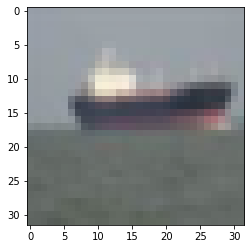

In [17]:
plt.imshow(X_train[69])

Data cleaning

In [18]:
#Dimensionality reduction: #Ya no se hará reduccion de dimensionalidad, la usar Batch Normalization
X_train= X_train.astype('float32')/255
X_test= X_test.astype('float32')/255

In [32]:
#Restructuring the labels
num_class= len(np.unique(y_train)) #10 possibles values
y_train= to_categorical(y_train, num_class)
y_test= to_categorical(y_test, num_class)

In [20]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

Normalization

In [33]:
#mean, std
mean= np.mean(X_train)
std= np.std(X_train)


In [34]:
#Test and train: Para evitar conflictos, se dividirá con la data train. Para evitar sesgos
X_train= (X_train - mean) / (std + 1e-7)
X_test=(X_test - mean) / (std + 1e-7)

Data Validation

In [35]:
(X_train, X_valid)= X_train[5000:], X_train[:5000]
(y_train, y_valid)= y_train[5000:], y_train[:5000]

print('X_train Shape', X_train.shape)
print('X_valid Shape', X_valid.shape)
print('X_test Shape', X_test.shape)
print('<==============================>')
print('y_train Shape', y_train.shape)
print('y_test Shape', y_train.shape)
print('y_valid Shape', y_valid.shape)

X_train Shape (45000, 32, 32, 3)
X_valid Shape (5000, 32, 32, 3)
X_test Shape (10000, 32, 32, 3)
<==============================>
y_train Shape (45000, 10)
y_test Shape (45000, 10)
y_valid Shape (5000, 10)


Creacion del modelo

In [36]:
base_filtros= 32
w_regularizers= 1e-4 #learning rate

Agregando Batch Normalization

In [37]:
#@title Texto de título predeterminado
model= Sequential()
#Convolution num 1
model.add(Conv2D(base_filtros,(3,3), padding='same', kernel_regularizer= regularizers.l2(w_regularizers), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
#Convolution num 2
model.add(Conv2D(base_filtros,(3,3), padding='same', kernel_regularizer= regularizers.l2(w_regularizers)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.22))

#Convolution num 3 
model.add(Conv2D(base_filtros*2,(3,3), padding='same', kernel_regularizer= regularizers.l2(w_regularizers)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(BatchNormalization())
model.add(Dropout(0.22))

#Convolution num 4
model.add(Conv2D(base_filtros*2,(3,3), padding='same', kernel_regularizer= regularizers.l2(w_regularizers)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.32))

#Convolution num 5
model.add(Conv2D(base_filtros*4,(3,3), padding='same', kernel_regularizer= regularizers.l2(w_regularizers)))
model.add(Activation('relu'))
model.add(BatchNormalization())

#Convolution num 6
model.add(Conv2D(base_filtros*2,(3,3), padding='same', kernel_regularizer= regularizers.l2(w_regularizers)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.42))

#Clasification- Flatten
model.add(Flatten())
model.add(Dense(num_class, activation= 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                      

New Image Generator

In [43]:
datagen=ImageDataGenerator(
                   rotation_range=15,
                   width_shift_range=0.1,
                   height_shift_range=0.1,
                   horizontal_flip=True,
                   vertical_flip=True,
                   zoom_range=0.2,
                   fill_mode='nearest',
                   brightness_range=[0.4,1.5]
                   )

Model Training

In [46]:
#new optimizer
from tensorflow.keras import optimizers

In [49]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])

In [ ]:
chekpoint= ModelCheckpoint('Mi mejor modelo.hdf5', verbose=1, save_best_only=True, monitor='val_accuracy')

#creacion del modelo
hist=model.fit(datagen.flow(X_train, y_train, batch_size=128), 
               callbacks=[chekpoint],steps_per_epoch=X_train.shape[0]//128, 
               epochs=120, 
               verbose=2, 
               validation_data=(X_valid, y_valid))

Epoch 1/120

Epoch 1: val_accuracy improved from -inf to 0.28120, saving model to Mi mejor modelo.hdf5
351/351 - 58s - loss: 2.3238 - accuracy: 0.2748 - val_loss: 1.9687 - val_accuracy: 0.2812 - 58s/epoch - 166ms/step
Epoch 2/120

Epoch 2: val_accuracy improved from 0.28120 to 0.42160, saving model to Mi mejor modelo.hdf5
351/351 - 44s - loss: 1.8302 - accuracy: 0.3808 - val_loss: 1.6565 - val_accuracy: 0.4216 - 44s/epoch - 126ms/step
Epoch 3/120

Epoch 3: val_accuracy improved from 0.42160 to 0.47940, saving model to Mi mejor modelo.hdf5
351/351 - 44s - loss: 1.6465 - accuracy: 0.4366 - val_loss: 1.4770 - val_accuracy: 0.4794 - 44s/epoch - 126ms/step
Epoch 4/120

Epoch 4: val_accuracy improved from 0.47940 to 0.53140, saving model to Mi mejor modelo.hdf5
351/351 - 43s - loss: 1.5087 - accuracy: 0.4822 - val_loss: 1.3837 - val_accuracy: 0.5314 - 43s/epoch - 123ms/step
Epoch 5/120

Epoch 5: val_accuracy improved from 0.53140 to 0.53720, saving model to Mi mejor modelo.hdf5
351/351 - 44s

In [ ]:
#hist= model.fit(X_train, y_train, batch_size=35, epochs=40, validation_data= (X_valid, y_valid), verbose=2, shuffle=True)

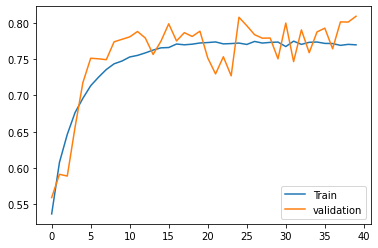

In [ ]:
plt.plot(hist.history['accuracy'], label= 'Train')
plt.plot(hist.history['val_accuracy'], label= 'validation')
plt.legend()
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 0.7499 - accuracy: 0.7899


[0.7499261498451233, 0.789900004863739]